# Spark Data Analysis

In this notebook, we will learn how to perform simple data analytics tasks. We will start with basic operations on a simple file, then we use the data from the airline stats.

We will explore the different Spark operations, i.e., **trasformations** and **actions**, through a set of questions.
Recall that *trasformations* are lazily evaluated, they get execute when we call an *action*.

Examples of *transformations* are:
 - Narrow: map, flatMap, filter, sample, union, ...
 - Wide: reduceByKey, groupByKey, join, repartition, ...

Examples of *actions* are:
 - count, collect, take, top, saveAsTextFile, ...


# 1. Basic operations with Spark
In the following, we provide some useful operations in Spark. For a complete list, see the following reference

https://spark.apache.org/docs/latest/rdd-programming-guide.html

## 1.1. Loading the Dataset

The RDD we analyze can be derived either from a collection of data or HDFS (most common case).

Parallelized collections are created by calling `SparkContext`’s `parallelize` method on an existing iterable or collection in your driver program. The elements of the collection are copied to form a distributed dataset that can be operated on in parallel. For example, here is how to create a parallelized collection holding the numbers 1 to 5:

```python
data = list(range(1,1000))
distData = sc.parallelize(data)
```

It is possible to specify the number of partitions to cut the dataset into (e.g., if we want to split into 5 partitions, we use `sc.parallelize(data, 5)`). Typically you want 2-4 partitions for each CPU in your cluster. Normally, Spark tries to set the number of partitions automatically based on your cluster. 

Data from HDFS (or any other storage) can be loaded into an RDD
Spark can create RDD from any storage source supported by Hadoop, including your local file system, HDFS, HBase, etc. Spark supports text files, SequenceFiles, and any other Hadoop InputFormat.

Text file RDDs can be created using SparkContext’s textFile method. This method takes an URI for the file (either a local path on the machine, or a hdfs://, s3a://, etc URI) and reads it as a **collection of lines**. 

```python
input_file = sc.textFile("datasets/short_stories_I.txt")
```

Finally, you can save the results of a computation (most likely, an RDD) with:

```python
rddToBeSaved.saveAsTextFile("filename_with_path")
```

## 1.2. Persistence

If we are going to use an RDD multiple times, then we can explicitly tell Spark to keep it in RAM with `persist()`
```python
input_file.persist()
```
When you persist an RDD, each node stores any partitions of it that it computes in memory and reuses them in other actions on that dataset (or datasets derived from it). This allows future actions to be much faster.

In addition, each persisted RDD can be stored using a different *storage level*, allowing you, for example, to persist the dataset on disk and in memory. For a detailed discussion on RDD Persistence, please see

https://spark.apache.org/docs/latest/rdd-programming-guide.html#rdd-persistence

## 1.3. Operations: Actions

### Actions for seeing the output
Let's start with some basic **actions**. We have already seen `saveAsTextFile()` which trigger the computation and the writing to a file. We can instead see the results at the driver program with `collect()`, which returns the elements of the dataset as an array

```python
input_file.collect()
```

### count()

Actions that trigger the counting of the number of elements in an RDD
```python
input_file.count()
```

### take(n) and takeOrdered(n, [ordering])

`take(n)` returns an array with the first `n` elements of the dataset
```python
input_file.take(5)
```
`takeOrdered(n, [ordering])` returns the first `n` elements of the RDD using either their *natural order* or a custom comparator (note that now we use the RDD `distData`)
```python
distData.takeOrdered(5)
distData.takeOrdered(5, lambda x: -x)
```

## 1.4. Operations: Transformations

### map(func)
It returns a new RDD formed by passing *each element* of the source RDD through a function `func`.

We consider a simple function, and we apply it to the  RDD `distData`
```python
def square(x): 
    return x*x

distDataSquared = distData.map(square)
distDataSquared.take(5)
```
Another example: we would like to know the number of words in each line of a file 
```python
def wordsPerLine(s):
    words = s.split(" ")
    return len(words)

nWords = input_file.map(wordsPerLine)
nWords.take(5)
```
There is no need to explicit a different RDD at every operation (if we do not need them for other transformations), they can be combined together
```python
input_file.map(wordsPerLine).take(5)
```
Finally, for simple functions, we can use inline functions (lambda functions)
```python
distData.map(lambda x: x*x).take(5)
input_file.map(lambda line: len(line.split(" "))).take(5)
```

In [14]:

def wordsPerLine(s):
    words = s.split(" ")
    return len(words)

input_file = sc.textFile("dataset/short_stories_I.txt")
nWords = input_file.map(wordsPerLine)
inputNew = input_file.map(wordsPerLine).take(100)
print(inputNew)

[3, 1, 1, 15, 12, 3, 1, 13, 15, 8, 1, 15, 8, 1, 3, 1, 9, 1, 2, 1, 12, 1, 5, 1, 13, 1, 15, 8, 1, 17, 5, 1, 3, 1, 15, 14, 16, 1, 1, 4, 1, 16, 10, 1, 12, 14, 14, 16, 16, 12, 12, 15, 11, 14, 15, 14, 13, 1, 1, 10, 1, 16, 4, 1, 14, 15, 13, 14, 15, 13, 12, 11, 1, 1, 12, 15, 12, 11, 13, 13, 11, 15, 9, 1, 15, 14, 13, 14, 1, 1, 4, 1, 7, 1, 7, 1, 12, 4, 1, 7]


### flatMap(func)
Similar to `map`, but the output is *flattened*. An example will make the difference clear.
```python
wordsWithMap = input_file.map(lambda line: line.split(" "))
wordsWithFlatMap = input_file.flatMap(lambda line: line.split(" "))
print(wordsWithMap.take(5))
print(wordsWithFlatMap.take(15))
```
Since the `split` method produces a list, then the RDD created with `map` will be a list of lists. Instead, with `flatMap` the lists are merged in a single output list.

In [15]:
wordsWithMap = input_file.map(lambda line: line.split(" "))
wordsWithFlatMap = input_file.flatMap(lambda line: line.split(" "))
print(wordsWithMap.take(40))
print()
print(wordsWithFlatMap.take(40))

[['AN', 'HONEST', 'THIEF'], [''], [''], ['One', 'morning,', 'just', 'as', 'I', 'was', 'about', 'to', 'set', 'off', 'to', 'my', 'office,', 'Agrafena,', 'my'], ['cook,', 'washerwoman', 'and', 'housekeeper,', 'came', 'in', 'to', 'me', 'and,', 'to', 'my', 'surprise,'], ['entered', 'into', 'conversation.'], [''], ['She', 'had', 'always', 'been', 'such', 'a', 'silent,', 'simple', 'creature', 'that,', 'except', 'her', 'daily'], ['inquiry', 'about', 'dinner,', 'she', 'had', 'not', 'uttered', 'a', 'word', 'for', 'the', 'last', 'six', 'years.', 'I,'], ['at', 'least,', 'had', 'heard', 'nothing', 'else', 'from', 'her.'], [''], ['"Here', 'I', 'have', 'come', 'in', 'to', 'have', 'a', 'word', 'with', 'you,', 'sir,"', 'she', 'began', 'abruptly;'], ['"you', 'really', 'ought', 'to', 'let', 'the', 'little', 'room."'], [''], ['"Which', 'little', 'room?"'], [''], ['"Why,', 'the', 'one', 'next', 'the', 'kitchen,', 'to', 'be', 'sure."'], [''], ['"What', 'for?"'], [''], ['"What', 'for?', 'Why', 'because', 'fo

### filter(func)
It returns a new RDD formed by selecting those elements of the source on which `func` returns true. Therefore, `func` should return a boolean value.

```python
input_file.filter(lambda line: len(line.split(" "))>5).take(10)
```

Note that this could not be with `map`, since with `map` each element maps to the element in the new RDD, and it cannot be omitted. For instance, try this
```python
input_file.map(lambda line: line if len(line.split(" "))>5 else None).take(10)
```

We can also use the `filter` to filter out empty lines from the file we are reading. We can use either `.filter(lambda x: x)` or, using the builtin function `bool`, `.filter(bool)`
```python
wordsWithMap = input_file.filter(bool).map(lambda line: line.split(" "))
wordsWithFlatMap = input_file.filter(bool).flatMap(lambda line: line.split(" "))
print(wordsWithMap.take(5))
print(wordsWithFlatMap.take(15))
```

Note that it is always better to filter before applying `map` (but the tool usually knows that, and it does it when translating the job into a set of tasks)
Note also that all the operations can be concatenated, as in the following example:
```python
lowerCaseWords = input_file.filter(bool) \
                    .flatMap(lambda line: line.split(" ")) \
                    .map(lambda w: w.lower())
print(lowerCaseWords.take(15))
```

In [17]:
#print(input_file.filter(lambda line: len(line.split(" "))>5).take(10))
#print('\n \n')
#print(input_file.map(lambda line: line if len(line.split(" "))>5 else None).take(10))

lowerCaseWords = input_file.filter(bool) \
                    .flatMap(lambda line: line.split(" ")) \
                    .map(lambda w: w.lower())
print(lowerCaseWords.take(15))

['an', 'honest', 'thief', 'one', 'morning,', 'just', 'as', 'i', 'was', 'about', 'to', 'set', 'off', 'to', 'my']


### Working with key-value pairs

Representing the data using a key-value is design pattern that is widely adopted to solve many problems, expecially when data need to be reorganized is different ways. For instace, it is common to group and aggregate elements by a key.

For this reason, Spark has a few special operations that are only available on RDDs of key-value pairs. A key-value element in a RDD is simply a tuple with two objects (e.g., a string and an int). 

It is simple to create a tuple from simple elements: just apply the `map` transformation.
```python
wordsList = input_file.filter(bool) \
            .flatMap(lambda line: line.split(" "))\ 
            .map(lambda w: w.lower())
wordsKeyValue = wordsList.map(lambda w: (w,1))
print(wordsKeyValue.take(10))
```

In [20]:
wordsList = input_file.filter(bool).flatMap(lambda line: line.split(" ")).map(lambda w: w.lower())
wordsKeyValue = wordsList.map(lambda w: (w,1))
print(wordsKeyValue.take(10))

[('an', 1), ('honest', 1), ('thief', 1), ('one', 1), ('morning,', 1), ('just', 1), ('as', 1), ('i', 1), ('was', 1), ('about', 1)]


### groupByKey()

When called on a dataset of (K, V) pairs, returns a dataset of (K, Iterable<V>) pairs.
*Note*: If you are grouping in order to perform an aggregation (such as a sum or average) over each key, using `reduceByKey` will yield much better performance.

Continuing the example above (except for the first line, the other are required to print the results):
```python
wordsGrouped = wordsKeyValue.groupByKey()
results = wordsGrouped.take(10)
for item in results:
    print(item[0], " > ", end='')
    for elem in item[1]:
        print(elem, ",", end='')
    print()
```

In [21]:
wordsGrouped = wordsKeyValue.groupByKey()
results = wordsGrouped.take(10)
for item in results:
    print(item[0], " > ", end='')
    for elem in item[1]:
        print(elem, ",", end='')
    print()

an  > 1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,
thief  > 1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,
just  > 1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,
as  > 1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,
i  > 1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,
was 

### reduceByKey(func)

When called on a dataset of (K, V) pairs, returns a dataset of (K, V) pairs where the values for each key are aggregated using the given reduce function `func`, which must be of type (V,V) => V.

Continuing the example above:
```python
wordsReduceBy = wordsKeyValue.reduceByKey(lambda a,b: a+b)
print(wordsReduceBy.take(10))
```

In [22]:
wordsReduceBy = wordsKeyValue.reduceByKey(lambda a,b: a+b)
print(wordsReduceBy.take(10))

[('an', 16), ('thief', 8), ('just', 13), ('as', 44), ('i', 238), ('was', 110), ('set', 8), ('agrafena,', 2), ('washerwoman', 1), ('housekeeper,', 1)]


### Wordcount - full example

As a final example, let's see the full Wordcount problem.
We are interested in the top-10 words in terms of number of occurrences.

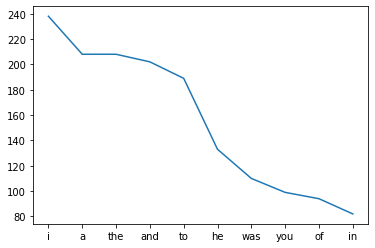

In [24]:
words = sc.textFile("dataset/short_stories_I.txt").filter(bool) \
            .flatMap(lambda line: line.split(" ")) \
            .map(lambda w: w.lower()) \
            .map(lambda w: (w, 1)) \
            .reduceByKey(lambda v1, v2: v1 + v2) \
            .map(lambda x: (x[1], x[0])) \
            .sortByKey(False)
top10 = words.take(10)
%matplotlib inline
import matplotlib.pyplot as plt

# extract the frequencies from the result
frequencies = [x[0] for x in top10]
x_indexes = list(range(0,10))
x_labels = [x[1] for x in top10]
plt.xticks(x_indexes, x_labels)

# plot the frequencies
plt.plot(frequencies)
plt.show()

# 2. Airline Data Analysis

## 2.1 Use case

In this notebook, we play the role of a data scientist working in the travel industry, specifically on air transportation of passengers. We want to explore the data related to airline activities to understand passengers' behavior, as well as the properties of all flights, across several airline companies.

The dataset can be found at
http://stat-computing.org/dataexpo/2009/the-data.html

It contains 29 features, that can be either categorical or numerical. For example, the ```Origin``` (source airport) is categorical: there exist no comparison operator between airport names. We can not say "SGN is bigger than NCE". The ```DepTime``` (departure time) feature is numerical, for which a comparison operator exists. For instance, "flight departing before 6PM" can be express by "DepTime < 1800". The structure of each line is as follows:

`
1	 Year	1987-2008
2	 Month	1-12
3	 DayofMonth	1-31
4	 DayOfWeek	1 (Monday) - 7 (Sunday)
5	 DepTime	actual departure time (local, hhmm)
6	 CRSDepTime	scheduled departure time (local, hhmm)
7	 ArrTime	actual arrival time (local, hhmm)
8	 CRSArrTime	scheduled arrival time (local, hhmm)
9	 UniqueCarrier	unique carrier code
10	 FlightNum	flight number
11	 TailNum	plane tail number
12	 ActualElapsedTime	in minutes
13	 CRSElapsedTime	in minutes
14	 AirTime	in minutes
15	 ArrDelay	arrival delay, in minutes
16	 DepDelay	departure delay, in minutes
17	 Origin	origin IATA airport code
18	 Dest	destination IATA airport code
19	 Distance	in miles
20	 TaxiIn	taxi in time, in minutes
21	 TaxiOut	taxi out time in minutes
22	 Cancelled	was the flight cancelled?
23	 CancellationCode	reason for cancellation (A = carrier, B = weather, C = NAS, D = security)
24	 Diverted	1 = yes, 0 = no
25	 CarrierDelay	in minutes
26	 WeatherDelay	in minutes
27	 NASDelay	in minutes
28	 SecurityDelay	in minutes
29	 LateAircraftDelay	in minutes
`

There is a single CSV file per year, you may download some years and put them in a directory. Then you could work on individual years, or feed the entire directory to your jobs such that you can process all years.

This is what the beginning of a file looks like:

`
Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
1994,1,7,5,858,900,954,1003,US,227,NA,56,63,NA,-9,-2,CLT,ORF,290,NA,NA,0,NA,0,NA,NA,NA,NA,NA
1994,1,8,6,859,900,952,1003,US,227,NA,53,63,NA,-11,-1,CLT,ORF,290,NA,NA,0,NA,0,NA,NA,NA,NA,NA
1994,1,10,1,935,900,1023,1003,US,227,NA,48,63,NA,20,35,CLT,ORF,290,NA,NA,0,NA,0,NA,NA,NA,NA,NA
1994,1,11,2,903,900,1131,1003,US,227,NA,148,63,NA,88,3,CLT,ORF,290,NA,NA,0,NA,0,NA,NA,NA,NA,NA
1994,1,12,3,933,900,1024,1003,US,227,NA,51,63,NA,21,33,CLT,ORF,290,NA,NA,0,NA,0,NA,NA,NA,NA,NA
1994,1,13,4,NA,900,NA,1003,US,227,NA,NA,63,NA,NA,NA,CLT,ORF,290,NA,NA,1,NA,0,NA,NA,NA,NA,NA
`

Each file contains a header, that is useless when analyzing the data: it serves the purpose of an "embedded schema", to help data scientist figure out what information is available. Note that there are some features with missing values in some lines of the dataset. The missing values are marked by "NA". These values can cause problems when processing the data and can lead to unexpected results. Therefore, we need to remove the header and replace all "NA" values by empty values, such as they can be interpreted as null values.

## 2.2 Data exploration

In order to start understanding the dataset, we may answer to some basic questions:

 - How many unique origin airports?
 - How many unique destination airports?
 - How many carriers?
 - How many night flights do we have in our data? ("night" starts at 6pm)
 - How many night flights per unique carrier?

Here there are some hints...
```python
# load the data
rawData = sc.textFile("datasets/1994_sample.csv")
# extract header
header = rawData.first() 
# remove the header, separate the elements for each row
data = rawData.filter(lambda row: row != header).map(lambda row : row.split(",")) 
# put the data in cache
data.persist()
# check the output
print(data.take(3))

# unique origin airports: element 16 of each line (the .keys() may not be necessary)
data.map(lambda x: (x[16], 1)).groupByKey().keys().count()


# flights that start after 6pm
data.filter(lambda x: x[4] != "NA" and int(x[4]) > 1800).count()


```

In [25]:
# load the data
rawData = sc.textFile("dataset/1994.csv")
# extract header
header = rawData.first() 
# remove the header, separate the elements for each row
data = rawData.filter(lambda row: row != header).map(lambda row : row.split(",")) 
# put the data in cache
data.persist()
# check the output
print(data.take(3))

# unique origin airports: element 16 of each line (the .keys() may not be necessary)
data.map(lambda x: (x[16], 1)).groupByKey().keys().count()

# flights that start after 6pm
data.filter(lambda x: x[4] != "NA" and int(x[4]) > 1800).count()


[['1994', '1', '7', '5', '858', '900', '954', '1003', 'US', '227', 'NA', '56', '63', 'NA', '-9', '-2', 'CLT', 'ORF', '290', 'NA', 'NA', '0', 'NA', '0', 'NA', 'NA', 'NA', 'NA', 'NA'], ['1994', '1', '8', '6', '859', '900', '952', '1003', 'US', '227', 'NA', '53', '63', 'NA', '-11', '-1', 'CLT', 'ORF', '290', 'NA', 'NA', '0', 'NA', '0', 'NA', 'NA', 'NA', 'NA', 'NA'], ['1994', '1', '10', '1', '935', '900', '1023', '1003', 'US', '227', 'NA', '48', '63', 'NA', '20', '35', 'CLT', 'ORF', '290', 'NA', 'NA', '0', 'NA', '0', 'NA', 'NA', 'NA', 'NA', 'NA']]


1120108

In [2]:
# load the data
rawData = sc.textFile("dataset/1994.csv")
# extract header
header = rawData.first() 
# remove the header, separate the elements for each row
data = rawData.filter(lambda row: row != header).map(lambda row : row.split(",")) 
# put the data in cache
data.persist()


PythonRDD[8] at RDD at PythonRDD.scala:53

In [40]:
import csv
# load the data
rawData = sc.textFile("dataset/movies.csv")
rawData2 = sc.textFile("dataset/ratings.csv")
# extract header
header = rawData.first() 
header2 = rawData2.first() 
# remove the header, separate the elements for each row
data = rawData.map(lambda row: next(csv.reader(row.splitlines(), skipinitialspace=True)))
data2 = rawData2.map(lambda row: next(csv.reader(row.splitlines(), skipinitialspace=True)))
#data = rawData.filter(lambda row: row != header).map(lambda row : row.split(",")) 
#data2 = rawData2.filter(lambda row: row != header2).map(lambda row : row.split(",")) 
# put the data in cache
data.persist()
data2.persist()
prova = data.join(data2)
tabella = spark.createDataFrame(data, ['id', 'title','genre'])
tabella2 = spark.createDataFrame(data2, ['userId','id','rating', 'timestamp' ])


movies = tabella.alias('movies')
ratings = tabella2.alias('ratings')
inner_join = movies.join(ratings, movies.id == ratings.id)
inner_join.show(50)


+------+--------------------+--------------+------+------+------+----------+
|    id|               title|         genre|userId|    id|rating| timestamp|
+------+--------------------+--------------+------+------+------+----------+
|100553|Frozen Planet (2011)|   Documentary|   105|100553|   4.5|1446572398|
|100553|Frozen Planet (2011)|   Documentary|   318|100553|   4.5|1426353247|
|102684|Only God Forgives...|Drama|Thriller|   249|102684|   3.5|1376654552|
|102684|Only God Forgives...|Drama|Thriller|   380|102684|   4.0|1494709199|
|  1090|      Platoon (1986)|     Drama|War|     1|  1090|   4.0| 964984018|
|  1090|      Platoon (1986)|     Drama|War|    17|  1090|   4.5|1322629080|
|  1090|      Platoon (1986)|     Drama|War|    36|  1090|   2.5|1100803399|
|  1090|      Platoon (1986)|     Drama|War|    42|  1090|   5.0| 996212773|
|  1090|      Platoon (1986)|     Drama|War|    51|  1090|   3.0|1230932491|
|  1090|      Platoon (1986)|     Drama|War|    59|  1090|   4.0| 953610028|

## 2.3 Various queries
In the following, there is a set of queries. Each result can be plot so that to better understand the results. For instance, the plot of the first query could be the airport code on the x-axis and the volume of traffic on the y-axis.

### Question Q1: Top 20 airports by total volume of flights
<div class="alert alert-info">
What are the busiest airports by total flight traffic. JFK will feature, but what are the others? For each airport code compute the number of inbound, outbound and all flights. Variation on the theme: compute the above by day, week, month, and over the years.
</div>

In [3]:
total_vol = (data.map(lambda x: (x[16],1))
                  .union(data.map(lambda x: (x[17],1)))
                  .reduceByKey(lambda a,b: a+b)
                  .takeOrdered(20, key = lambda x: -x[1]))
print(total_vol)


[('ORD', 561461), ('DFW', 516523), ('ATL', 443074), ('LAX', 306453), ('STL', 304409), ('DEN', 285526), ('PHX', 280560), ('DTW', 276272), ('PIT', 262939), ('CLT', 259712), ('MSP', 247980), ('SFO', 235478), ('EWR', 233991), ('IAH', 208591), ('LGA', 203362), ('BOS', 199696), ('LAS', 189920), ('PHL', 186897), ('DCA', 176115), ('MCO', 153720)]


In [10]:
total_vol = (data.map(lambda x: ((x[16], x[1]),1))
                  .union(data.map(lambda x: ((x[17], x[1]), 1)))
                  .reduceByKey(lambda a,b: a+b))
                  
total_fliter_jan = (total_vol.filter(lambda x: (int(x[0][1]) == 1)).takeOrdered(20, key = lambda x: -x[1]))#gennaio

print(total_fliter_jan)

[(('ORD', '1'), 47070), (('DFW', '1'), 43052), (('ATL', '1'), 38734), (('DEN', '1'), 25839), (('LAX', '1'), 24418), (('PHX', '1'), 23005), (('STL', '1'), 22627), (('DTW', '1'), 21641), (('PIT', '1'), 21034), (('CLT', '1'), 20046), (('MSP', '1'), 19945), (('SFO', '1'), 19245), (('EWR', '1'), 19168), (('LGA', '1'), 17179), (('BOS', '1'), 16806), (('IAH', '1'), 16267), (('PHL', '1'), 15782), (('LAS', '1'), 15078), (('DCA', '1'), 14610), (('MIA', '1'), 12281)]


### Question Q2: Carrier Popularity
<div class="alert alert-info">
Some carriers come and go, others demonstrate regular growth. Compute the (log base 10) volume -- total flights -- over each year, by carrier. The carriers are ranked by their median volume (over the 4 year span).
</div>

### Question Q3: Proportion of Flights Delayed
<div class="alert alert-info">
A flight is delayed if the delay is greater than 15 minutes. Compute the fraction of delayed flights per different time granularities (hour, day, week, month, year).
</div>

### Question Q4: Carrier Delays
<div class="alert alert-info">
Is there a difference in carrier delays? Compute the proportion of delayed flights by carrier, ranked by carrier, at different time granularities (hour, day, week, month year). Again, a flight is delayed if the delay is greater than 15 minutes.
</div>

### Question Q5: Busy Routes
<div class="alert alert-info">
Which routes are the busiest? A simple first approach is to create a frequency table for the unordered pair *(i,j)* where *i* and *j* are distinct airport codes.
</div>